**Homework 3: Implementation of a classifier perceptron for binary classification**

Universidad de Monterrey

Joel Enrique Díaz Villanueva

IMT

Dr. Andrés Hernández Gutiérrez

Monterrey, N.L., 19 de septiembre del 2024

### 1. Import standard libraries

In [1]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo # Paquete para importar conjuntos de datos desde el repositorio de machine learning de UC Irvine.
import pandas as pd # Proporciona estructuras de datos y herramientas para el análisis eficiente de datos tabulares, series temporales y matrices etiquetadas o no etiquetadas.
import plotly.express as px # Permite crear diversas figuras a la vez.
import seaborn as sns
import matplotlib.pyplot as plt # Está diseñada para crear gráficos y visualizaciones interactivas de datos, por ejemplo, para trazar las curvas de aprendizaje y evaluar el proceso de entrenamiento.
import numpy as np # Se utiliza para crear arreglos multidimensionales y realizar operaciones matemáticas, lógicas y de álgebra lineal, además de la generación de números aleatorios.
import tensorflow as tf #  Librería desarrollada por Google, es de las más utilizadas para diseñar, entrenar, validar y probar el desarrollo de una red neuronal.
from sklearn.model_selection import train_test_split # Esta biblioteca proporciona el método train_test_split para dividir el conjunto de datos inicial en los conjuntos de entrenamiento y validación.
from sklearn.preprocessing import StandardScaler # Estándariza las características eliminando la media y escalando a una varianza unitaria. (z = (x - u) / s)
from sklearn.metrics import ConfusionMatrixDisplay # Se utiliza para gráficar en una matriz una comparación entre los valores reales y predichos


Se instalan e importan las bibliotecas necesarias para el código.


### 2. Download the ```occupancy-detection``` dataset

For further information regarding this dataset, visit the UC Irving Machine Learning Repository [here](https://archive.ics.uci.edu/dataset/357/occupancy+detection).

In [2]:
# Download `occupancy-detection` dataset
# using the id=357
occupancy_detection = fetch_ucirepo(id=357) # Se descarga el dataset "ocuppancy-detection".

# Build the feature and the target data sets
data = occupancy_detection.data.original # Se le asigna la variable data a los datos originales de este dataset.

Se descarga el dataset "ocuppancy-detection".

### 3. Perform an exploratory data analysis

In [3]:
df = data.drop(['date', 'id'], axis=1) # Se remueven datos innecesarios como las columnas del id y la fecha.
df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce') # Se convierte todo el dataframe a valores numéricos para garantizar que no haya problemas con los cálculos posteriores.
df = df.dropna() # Se elimina cualquier fila que contenga valores NaN.

Se eliminan datos innecesarios para predecir la occupancy en una habitación.

#### 3a. Print some samples of the ```features``` and the ```target``` variables

In [4]:
df # Se visualiza el data frame.

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.180,27.2720,426.00,721.25,0.004793,1.0
1,23.150,27.2675,429.50,714.00,0.004783,1.0
2,23.150,27.2450,426.00,713.50,0.004779,1.0
3,23.150,27.2000,426.00,708.25,0.004772,1.0
4,23.100,27.2000,426.00,704.50,0.004757,1.0
...,...,...,...,...,...,...
20557,20.815,27.7175,429.75,1505.25,0.004213,1.0
20558,20.865,27.7450,423.50,1514.50,0.004230,1.0
20559,20.890,27.7450,423.50,1521.50,0.004237,1.0
20560,20.890,28.0225,418.75,1632.00,0.004279,1.0


Visualización del dataframe.

#### 3b. Obtain statistics about the ```features``` and the ```target``` variables

In [5]:
df.describe() # Genera un resumen estadístico del dataframe, obteniendo información como: el número de datos, promedio, desviación estándar, valor mínimo, el valor por debajo del cual se encuentra el 25%, el valor que separa a los datos en dos partes iguales, el valor por debajo del cual se encuentra el 75% de los datos y el valor máximo.

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


Se genera un resumen estadístico del dataframe, esto es importante para una detección temprana de posibles sesgos, donde cierta entrada pueda obtener un mayor peso a comparación de las demás.


#### 3c. Visualise a scatter matrix plot using ```plotly``` to visualise the relationships between features

In [6]:
# Scatter plot matrix
features = df.drop(["Occupancy"], axis=1).columns # Se elimina la columna occupancy.
fig = px.scatter_matrix(data_frame=df, # Se crea una matriz de gráficos de dispersión con los datos del DataFrame.
                        dimensions=features, # Se especifican las columnas a incluir en el gráfico, sin occupancy.
                        color=df['Occupancy']) # Se utiliza la columna 'Occupancy' para colorear los puntos en función de la ocupación.
fig.update_traces(marker = dict(size=4), diagonal_visible=False, showupperhalf=False) # Se actualiza el tamaño de los marcadores, se ocultan las diagonales y se muestra solo la mitad inferior de la matriz.
fig.update_layout(width=900, height=600, title="Occupancy Detection", font_size=9) # Se ajustan las dimensiones del gráfico, se personaliza el título y el tamaño de la fuente del gráfico.
fig.show() # Se muestra la matriz con los gráficos de dispersión.

El uso de las matrices de gráficas de dispersión permite ver si hay alguna correlación visual entre las variables y la ocupación. En este caso, desde mi punto de vista, se puede analizar como en las gráficas de la luz, la luz y la humedad, la luz y el CO2 hay una agrupación más notoria respecto a la occupancy, lo que significa que quizás sean las variables con mayor peso para determinar si está ocupada o no la habitación.

#### 3d. Visualise a pair plot to using ```seaborn``` to capture the relatioshops between features

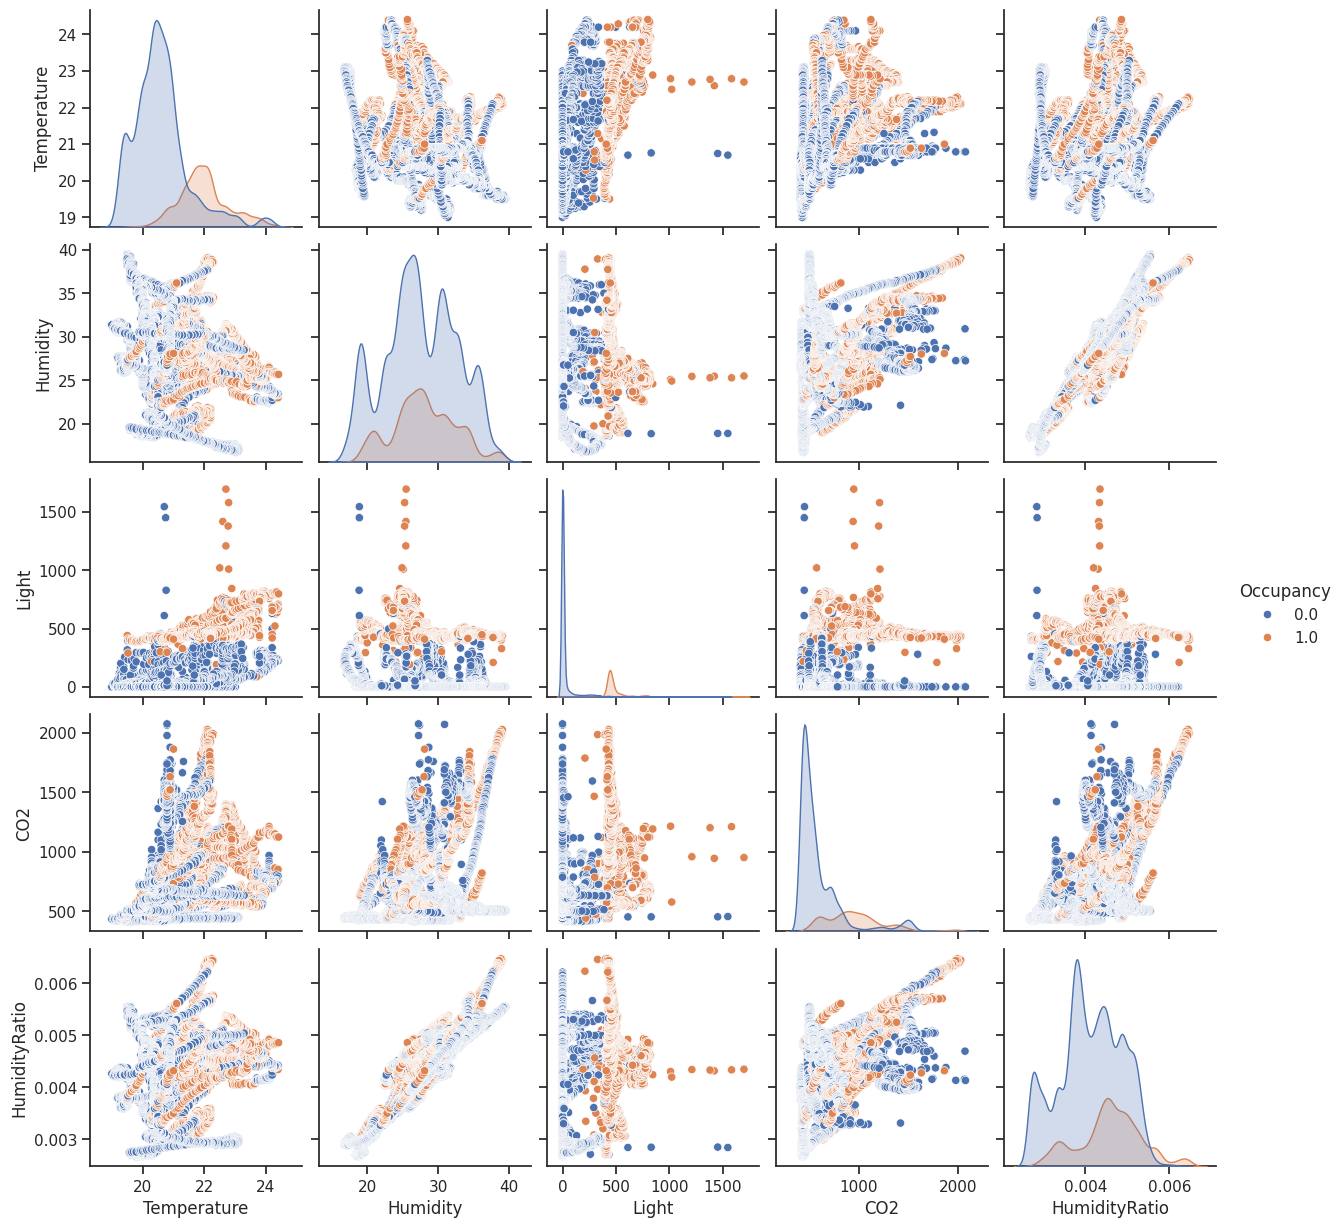

In [7]:
sns.set_theme(style="ticks") # Se estable el estilo del gráfico de pares.
sns.pairplot(df, hue="Occupancy"); # Se crea un gráfico de pares para visualizar la relación entre todas las variables del dataframe.

En esta gráfica de pares nuevamente se puede observar como la relación entre pares de las entradas de la temperatura, luz, el CO2 y la humedad, hay una agrupación más notoria para predecir si una habitación está ocupada o no.

#### 3e. Visualise the histogram of classes

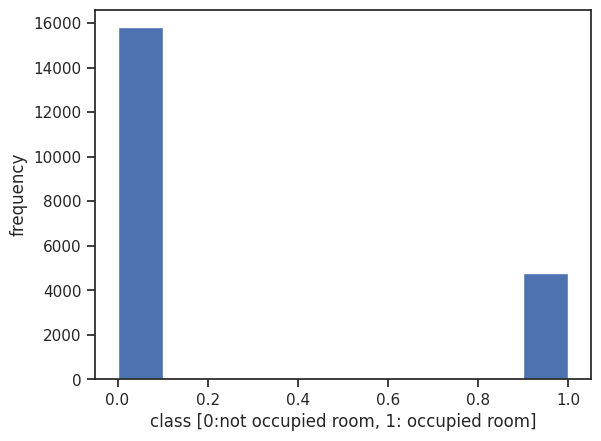

In [8]:
plt.hist(df['Occupancy']); # Se crea un histograma de la columna occupancy del dataframe.
plt.xlabel('class [0:not occupied room, 1: occupied room]') # Se etiqueta el eje x para indicar lo que representa: 0 para no ocupado y 1 para ocupado.
plt.ylabel('frequency'); # Se etiqueta el eje Y para mostrar que representa la frecuencia de las clases.

En el histograma se observa un notable desbalance en la distribución de las habitaciones ocupadas y las no ocupadas.

### 4. Training and evaluate your model

#### 4a. For reproducibility purposes only, set a particular seed number

In [9]:
# Set a global seed for reproducibility
tf.random.set_seed(4500) # Se fija una semilla para obtener respuestas similares al trabajar con números aleatorios.

Esta semilla sirve para obtener resultados similares al trabajar con números aleatorios, sin importar desde donde se trabaje.


#### 4b. Build your feature and target sets

In [10]:
X = df.drop(["Occupancy"], axis=1) # Se elimina la columna occupancy para las entradas (X).
y = df['Occupancy']  # El occupancy se convierte en la salida o Y, para predecir si esta ocupada o no la habitación.

Se establece la columna occupancy como la salida, o el objetivo a predecir, y los demás datos como las entradas.

#### 4c. Split your original data set into the training and testing sets

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True) # Se separan los datos de entrenamiento y prueba, corresponiendo el 80% de los datos a el entrenamiento y el resto para prueba, con un random state de 42, para obtener respuestas similares al trabajar con aleatoriedad, además de la inclusión de la función shuffle, ayuda a que exista más esparcimiento entre los datos.

Se separan los datos de entrada y salida como datos de entrenamiento y de prueba.

#### 4d. Apply feature scaling and transform the training and testing sets

In [12]:
# Standardise features
scaler = StandardScaler() # Herramienta para estandarizar datos y evitar sesgos.
X_train = scaler.fit_transform(X_train) # Estandariza los datos de x train.
X_test = scaler.transform(X_test) # # Estandariza los datos de x test.

Se estandarizan los datos de entrada para evitar sesgos.

#### 4e. Design your model architecture

In [13]:
# Define the model
def get_model():
    model = tf.keras.Sequential([  # Se crea un modelo secuencial de Keras.
        tf.keras.layers.InputLayer(shape=(5,)), # Se establecen 5 entradas para: temperatura, humedad, luz, co2 y relación de humedad.
        tf.keras.layers.Dense(1, activation='sigmoid') # Capa con solamente una neurona, y con la función de activación sigmoidal.
    ])
    return model

Se define la configuración de la red neuronal, con 5 entradas, una neurona en la capa oculta, y la implementación de la función de activación sigmoidal para clasificaciones binarias.

#### 4f. Print the summary of your model parameters

In [14]:
model = get_model() # Se obtiene el modelo.
model.summary() # Se devuelve un análisis del modelo.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Se muestra un resumen de la red neuronal, con 6 parámetros, los cuales son 5 de entrada y 1 de salida.

#### 4g. Configure the optimiser, loss function and metrics for training purposes

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Se utiliza el compilador adam y la función de pérdida crossentropy.

Se establece el compilador adam y la función de pérdida crossentropy, está, es utilizada principalmente para clasificaciones binarias.

In [16]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test) # Se evalua la precisión del modelo con el conjunto de entrenamiento antes de entrenar.
print(f"Test Accuracy: {accuracy:.4f}") # Se muestran los resultados.

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2097 - loss: 1.3014
Test Accuracy: 0.2118


Se muestran los resultados del modelo sin entrenar, donde se observa una exactitud alta para no haber sido entrenada; sin embargo, está cuenta con una pérdida muy grande.

#### 4h. Fit your model to the training data set (training), using a 20% of it for validation purposes

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.20)  # Se entrena el modelo con los datos de entrenamiento, utilizando 20% de esos datos para validar la precisión del modelo.

Epoch 1/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2745 - loss: 1.1203 - val_accuracy: 0.5970 - val_loss: 0.7159
Epoch 2/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6800 - loss: 0.6425 - val_accuracy: 0.8167 - val_loss: 0.4740
Epoch 3/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8308 - loss: 0.4467 - val_accuracy: 0.8802 - val_loss: 0.3625
Epoch 4/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8808 - loss: 0.3489 - val_accuracy: 0.9091 - val_loss: 0.2954
Epoch 5/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9119 - loss: 0.2871 - val_accuracy: 0.9243 - val_loss: 0.2479
Epoch 6/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9282 - loss: 0.2423 - val_accuracy: 0.9380 - val_loss: 0.2114
Epoch 7/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9409 - loss: 0.2074 - val_accuracy: 0.9468 - val_loss: 0.1822
Epoch 8/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9504 - loss: 0.1793 - val_accuracy: 0.

Se muestran los resultados del entrenamiento de la red neuronal, con una exactitud y pérdida excelentes, tanto con los datos de entrenamiento y con los de validación, sin embargo, una observación es que la exactitud mayor en la época 31, a comparación de en la 50, pero la pérdida es menor en la última época a comparación de la época 31, por lo que, me gustaría saber cuál tiene un mayor impacto para saber cuál predice mejor, ambos son muy buenos, pero cuentan con falsos positivos y cosas por el estilo.

#### 4i. Visualise the learning curves for analysis purposes (overfitting / underfitting / right fitting)

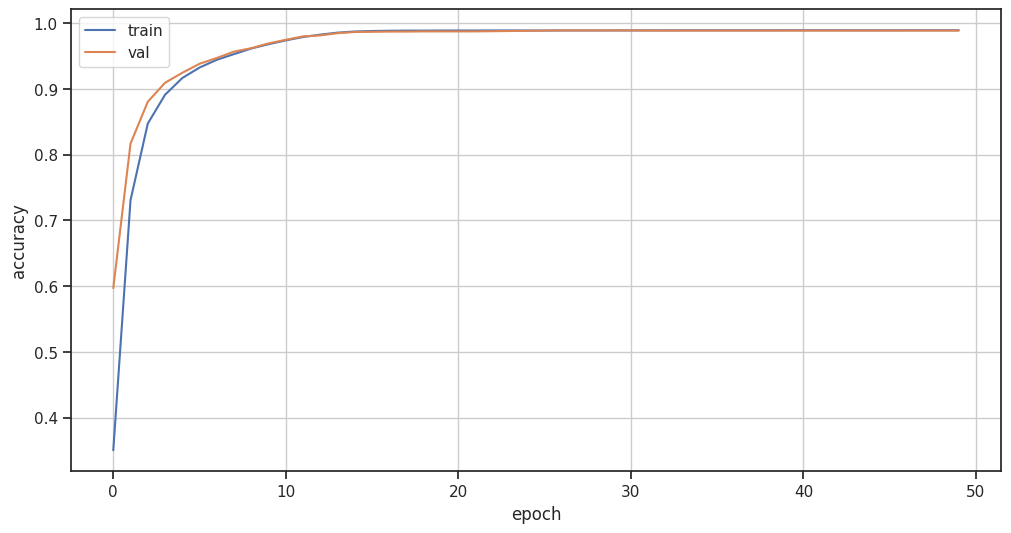

In [18]:
# Plot validation and testing accuracy
plt.figure(figsize=(12,6)) # Se establece el tamaño de la gráfica.
plt.plot(history.history['accuracy']) # Se gráfica la exactitud del modelo a través de las épocas.
plt.plot(history.history['val_accuracy']) # Se gráfica la exactitud del modelo con los datos de validación del entrenamiento a través de las épocas.
plt.xlabel('epoch') # El eje x corresponde a las épocas.
plt.ylabel('accuracy') # El eje y corresponde a las exactitud.
plt.legend(['train', 'val']) # Se añade una leyenda para distinguir entre entrenamiento y validación.
plt.grid(); # Se añade una cuadrícula a la gráfica para mejorar la legibilidad.

Se grafica la exactitud a través de las épocas, donde nuevamente se observa que es mayor en la época 31 a comparación de en la 50.

#### 4j. Visualise the learning curves for analysis purposes (overfitting / underfitting / right fitting)

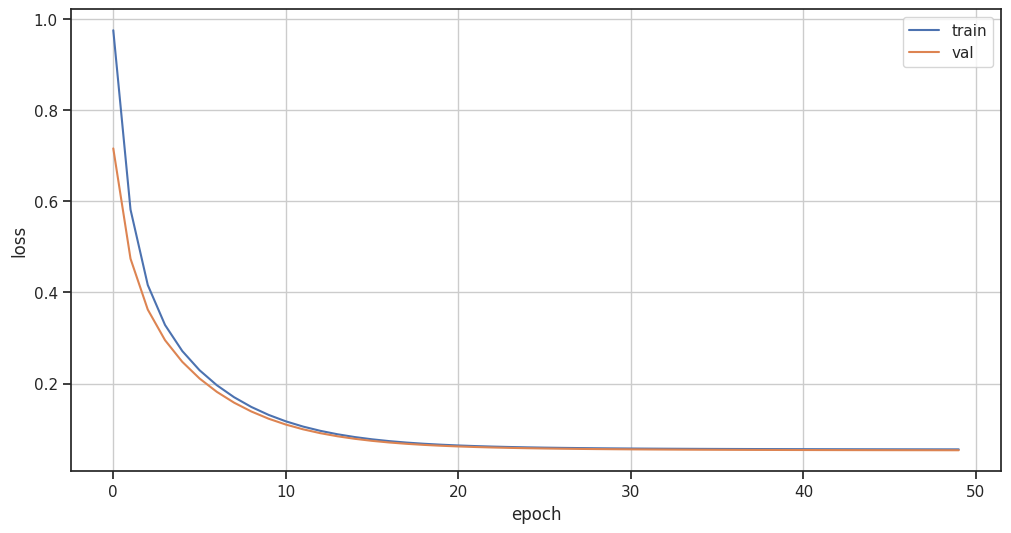

In [19]:
# Plot validation and testing loss
plt.figure(figsize=(12,6)) # Se establece el tamaño de la gráfica.
plt.plot(history.history['loss']) # Se gráfica la pérdida del conjunto de entrenamiento a lo largo de las épocas.
plt.plot(history.history['val_loss']) # Se gráfica la pérdida con los datos de validación del entrenamiento a lo largo de las épocas.
plt.xlabel('epoch') # El eje x corresponde a las épocas.
plt.ylabel('loss') # El eje y corresponde a la pérdida.
plt.legend(['train', 'val'])  # Se añade una leyenda para distinguir entre entrenamiento y validación.
plt.grid(); # Se añade una cuadrícula a la gráfica para mejorar la legibilidad.

Se grafica el error a través de las épocas donde nuevamente se observa que el mínimo se encuentra en la última época. Se observa que el modelo parece ser un caso de right fitting, debido a que está aprendiendo bien tanto en los datos de prueba como en los de validación.

In [20]:
# Print weights
weights = model.layers[0].get_weights() # Se muestran los pesos de las entradas.
print(weights) # Se muestran los pesos.

[array([[-0.8681875 ],
       [-0.06283156],
       [ 4.4847665 ],
       [ 0.98655957],
       [ 0.45121032]], dtype=float32), array([-3.9510267], dtype=float32)]


Se observan los pesos obtenidos con la función de pérdida minimizada, donde la luz, es el que tiene el mayor valor absoluto, seguido del CO2 y después la temperatura, lo que coincide con mi análisis anterior.

#### 4k. Evaluate the accuracy of the learnt model using the testing set

In [21]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test) # Se evalua el modelo con los datos de prueba.
print(f"Test Accuracy: {accuracy:.4f}") # Se muestra la precisión y la pérdida.

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9896 - loss: 0.0512
Test Accuracy: 0.9895


Se evalúa la exactitud del modelo, comparando las predicciones contra los valores reales, con los datos de prueba.


#### 4l. Apply the learnt model to new data (run the next cell multiple times)

In [22]:
# Predict on new data
indx = np.random.randint(low=0, high=y_test.shape[0]) # Se genera un índice aleatorio dentro del rango de y_test.
xi = np.array([X_test[indx,:]]) # Se selecciona una fila de X_test usando el índice aleatorio.
prediction = model.predict(xi) # Se realiza la predicción
print(f"Input: {xi} \t Target: {y_test.iloc[indx]} \t Prediction: {prediction[0][0]:.4f}") # Se muestran los resultados, tanto los datos de entrada, la salida verdadera y la predicha.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input: [[-0.01808606 -0.51852611 -0.62088614 -0.43017688 -0.52377999]] 	 Target: 0.0 	 Prediction: 0.0006


Se selecciona aleatoriamente una fila de datos de prueba (X_test), para posteriormente realizar una predicción utilizando el modelo entrenado.

### 5. Compute performance metrics

In [23]:
from sklearn.metrics import confusion_matrix

y_predictions = model.predict(X_test) > 0.5 # Se convierten las probabilidades en predicciones binarias (0 o 1).
c_matrix = confusion_matrix(y_true=y_test, y_pred=y_predictions) # Se calcula la matriz de confusión comparando los valores reales con las predicciones.

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Se establece la matriz de confusión.

#### 5a. Compute confusion matrix

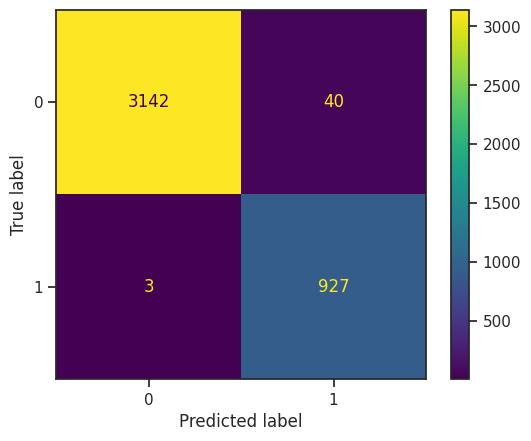

In [24]:
display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix) # Se crea el display para la matriz de confusión
display_matrix.plot() # Se muestra la matriz de confusión

Se observa un total de 3142 verdaderos negativos, 40 falsos negativos y un total de 3 falsos negativos y 927 verdaderos positivos utilizando los datos de prueba y los predichos.

#### 5b. Compute performance metrics

In [25]:
def get_performance_metrics(c_matrix):
    tn, fp, fn, tp = c_matrix[0][0], c_matrix[0][1], c_matrix[1][0], c_matrix[1][1] # Se obtienen los datos de la matriz de confusión, (verdaderos negativos, falsos positivos, falsos negativos y verdaderos positivos).

    accuracy = (tp + tn) / (tp + tn + fp + fn) # Exactitud.
    precision = tp / (tp + fp) # Precisión.
    recall = tp / (tp + fn) # Sensibilidad o Recall.
    specificity = tn / (tn + fp) # Especificidad.
    f1_score = 2 * (precision * recall)/(precision + recall) # F1-score.
    return accuracy, precision, recall, specificity, f1_score # Se devuelven los valores de las métricas de rendimiento.

accuracy, precision, recall, specificity, f1_score = get_performance_metrics(c_matrix) # Se obtienen las métricas de desempeño usando la matriz de confusión.

# Se imprimen los resultados con 6 decimales
print(f"Accuracy: {accuracy:0.6f}")
print(f"Precision: {precision:0.6f}")
print(f"Recall: {recall:0.6f}")
print(f"Specificity: {specificity:0.6f}")
print(f"F1-score: {f1_score:0.6f}")

Accuracy: 0.989543
Precision: 0.958635
Recall: 0.996774
Specificity: 0.987429
F1-score: 0.977333


El modelo muestra un rendimiento excelente, con métricas que indican, muy pocos errores (alta precisión y exactitud), además de muy buena capacidad para detectar correctamente tanto las habitaciones ocupadas como las no ocupadas.

**Conclusión:**

Como conclusión, me quedó con el modelo desarrollado en la sección B, este supera en exactitud, precisión, especificidad y F1-score al propuesto en la sección A, teniendo el mismo resultado en el parámetro restante. Sin embargo, al implementar la función de la actualización de costos de manera manual, el código A termino siendo aún más complejo, a comparación del de la sección B, donde toda esa parte fue una línea de código. Además, en el código de la sección A se le asignó un learning rate muy alto de 1, cuando el predeterminado de TensorFlow es de 0.001, en la clase al probar con este learning rate, se tardó una gran cantidad de tiempo en compilar esa sección del código, y con un learning rate muy alto puede llevar al riesgo de que el modelo no converja de manera correcta, por lo que me quedó con el código de la sección B, debido a que mostró mejores resultados y en un menor tiempo de iteración.

**Referencias:**

Scikit-Learn. (n.d.) StandardScaler. Recuperado el 18 de septiembre del 2024 de: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessingStandardScaler.html

SciPy. (n.d.). scipy.special.expit. Recuperado el 18 de septiembre del 2024 de: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html

Saturn Cloud. (2023). Understanding the Differences Between Numpy Reshape(-1, 1) and Reshape(1, -1). Recuperado el 18 de septiembre del 2024 de: https://saturncloud.io/blog/understanding-the-differences-between-numpy-reshape1-1-and-reshape1-1/

Shah, N. (2018). Introduction to NumPy, Pandas and Matplotlib. Recuperado el 18 de septiembre del 2024 de: https://www.kaggle.com/code/chats351/introduction-to-numpy-pandas-and-matplotlib

Scikit-Learn. (n.d.) ConfusionMatrixDisplay. Recuperado el 19 de septiembre del 2024 de: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

Plotly. (n.d.). Plotly Express in Python. Recuperado el 19 de septiembre del 2024 de: https://plotly.com/python/plotly-express/

seaborn. (n.d.). An introduction to seaborn — seaborn 0.13.2 documentation. Recuperado el 19 de septiembre del 2024 de: https://seaborn.pydata.org/tutorial/introduction.html